# Covid dataset
##### The majority of codes except for the model and data preprocessing can be found on NPF ()
#####  Please also cite their work when

In [1]:
import os
import logging
import warnings
import torch
from utils.ntbks_helpers import (get_covid_datasets,
                                 add_y_dim)
from utils.data import cntxt_trgt_collate_covid
from functools import partial
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from utils.helpers import count_parameters
from npf import ELBOLossLNPF

from npf.neuralproc.gbconpgrid import GridGlobalConvNP
from utils.train import train_models
from utils.evaluate import test_with_loglikelihood, quantify_global_uncertainty
from npf.utils.helpers import make_abs_conv
from utils.visualize.visualize_imgs import save_plot_spatial
from npf.utils.datasplit import (
    CovidTimeMasker,
    CovidCntxtTrgtGetter,
    CovidGridCntxtTrgtGetter,
    no_masker
)
from skorch.callbacks import GradientNormClipping
import skorch

# Covid Dataset downloading and preprocessing

Download the [Covid.zip](https://drive.google.com/file/d/1J3aWFE7m8hYwE9dVaeL8-bK0gRc8QX7Y/view?usp=sharing) used in the paper. The time in the dataset started from 21/01/2020 to 20/04/2021.
If you want to generate the up-to-date Covid dataset, pleases visit [link](https://www.kaggle.com/fireballbyedimyrnmom/us-counties-covid-19-dataset) and download the "us-counties.csv",
then refer to the function "save_log_relative_growth" and "save_images" to transform the county case numbers into geographical graphs 

In [2]:
#Data Analyses Libraries
import pandas as pd
from urllib.request import urlopen
import json
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import os
import numpy as np

def save_log_relative_growth():
    root = "/share/scratch/xuesongwang/metadata/Covid/"
    usa_cases = pd.read_csv(os.path.join(root, "us-counties.csv"))
    new_df = pd.DataFrame()
    for _, df_county in usa_cases.groupby("fips"):
        for back_shift_day in range(0, 15):
            # calculate last 14 days
            df_county_day = df_county['cases'].shift(periods=back_shift_day)
            df_county_day.fillna(0, inplace=True)
            df_county['back'+str(back_shift_day)+'days'] = df_county_day
            # calculate next 14 days
            if back_shift_day > 0:
                df_county_day = df_county['cases'].shift(periods=-back_shift_day)
                df_county_day.fillna(0, inplace=True)
                df_county['next' + str(back_shift_day) + 'days'] = df_county_day

        # find min value
        feature_list = ['back'+str(back_shift_day)+'days' for back_shift_day in range(15)] + \
                       ['next' + str(back_shift_day) + 'days' for back_shift_day in range(1, 15)]
        df_min = df_county[feature_list].min(axis=1)

        # logged relative growth rate
        logged = np.log(df_county[feature_list].values - np.expand_dims(df_min.values, axis=1) + 1)
        log_feature_list = ['Log_rel_'+feature for feature in feature_list]
        df_logged = pd.DataFrame(logged, index=df_county.index, columns=log_feature_list)
        df_county = pd.concat([df_county, df_logged], axis=1)

        # drop first and the last 14 rows, as they have 0 as min values for those days, and the log-relative growth can go row
        index = df_county.index
        df_county.drop(index[:15], inplace=True)
        df_county.drop(index[-15:], inplace=True)

        # form new df
        new_df = pd.concat([new_df, df_county], axis=0, ignore_index=True)

    # new_df.to_csv(os.path.join(root, "usa_new_cases.csv"))

def save_images(root = "/share/scratch/xuesongwang/metadata/Covid/"):
    usa_cases = pd.read_csv(os.path.join(root, "usa_new_cases.csv"))
    usa_cases['fips'] = usa_cases['fips'].astype(str).str.rjust(5, '0')
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)
    for date, county in tqdm(usa_cases.groupby('date')):
        count = county.back7days.sum()
        print("date: %s, total counties: %s, new cases in the last 7 days: %s" % (date, county.shape[0], count))
        # context images
        for shift_days in [7, 3, 0]:
            fig = px.choropleth(county, geojson=counties, locations='fips', color='Log_rel_back%ddays' % shift_days,
                                color_continuous_scale="gray",
                                range_color=(0, 13),
                                scope="usa")
            fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0},
                              coloraxis_colorbar=dict(title="log"))
            fig.update_traces(marker_line_width=0)
            # py.offline.iplot(fig)
            fig.write_image("covid_usa_back%d/%s.png" % (shift_days, date))
        # target images
        fig = px.choropleth(county, geojson=counties, locations='fips', color='Log_rel_next7days',
                            color_continuous_scale="gray",
                            range_color=(0, 13),
                            scope="usa")
        fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0},
                          coloraxis_colorbar=dict(title="log"))
        fig.update_traces(marker_line_width=0)
        # py.offline.iplot(fig)
        fig.write_image("covid_usa_next7/%s.png" % (date))

### Basic setting

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
N_THREADS = 4
torch.set_num_threads(N_THREADS)
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)




### get dataset

In [4]:
# DATASETS
img_datasets, img_val_datasets, img_test_datasets = get_covid_datasets(["Covid"], 
                                                                       root='/share/scratch/xuesongwang/metadata/Covid',
                                                                       patch_size=16)


### context-target split

In [5]:
# CONTEXT TARGET SPLIT
# 3d
get_cntxt_trgt_covid = cntxt_trgt_collate_covid(
    CovidGridCntxtTrgtGetter(
        context_masker=CovidTimeMasker(timestep=4), target_masker=no_masker,
    ),
    is_return_masks=True
)


### define model

In [6]:
# 3D
########### Original  #################################
R_DIM = 128
MODEL_KWARGS = dict(
    is_q_zCct=True,
    n_z_samples_train=4,
    n_z_samples_test=1,
    r_dim=R_DIM,
    z_dim=R_DIM//2,
    # z_dim = 4,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)

model_3d = partial(
    GridGlobalConvNP,
    x_dim=1,  # for gridded conv it's the mask shape
    Conv=lambda y_dim: make_abs_conv(torch.nn.Conv3d)(
        y_dim,
        y_dim,
        groups=y_dim,
        kernel_size=[5, 5, 5],
        padding=[5 // 2, 5 // 2, 5 // 2],
        bias=False,
    ),
    decoder_CNN=partial(
        CNN,
        n_channels=R_DIM,
        Conv=torch.nn.Conv3d,
        Normalization=torch.nn.BatchNorm3d,
        n_blocks=4,
        kernel_size=[5, 5, 5],
        **CNN_KWARGS,
    ),
    **MODEL_KWARGS,
)

n_params_3d = count_parameters(model_3d(y_dim=1))
print(f"Number Parameters (3D): {n_params_3d:,d}")

model_3d = add_y_dim(
    {"GBCoNP": model_3d}, img_datasets
)

Number Parameters (3D): 387,711


### load trainer

In [7]:
KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    criterion=ELBOLossLNPF, # NPML
    chckpnt_dirname="results/pretrained/",
    device=device,
    lr=1e-3,
    decay_lr=10,
    seed=123,
    batch_size=32,  # smaller batch because multiple samples
    callbacks=[
        GradientNormClipping(gradient_clip_value=1)
    ],  # clipping gradients can stabilize training
)

trainers_3d = train_models(
    img_datasets,
    model_3d,  # y_dim (channels) depend on data
    test_datasets=img_test_datasets,
    valid_datasets= img_val_datasets,  # use 10% of training for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_covid,
    iterator_valid__collate_fn=get_cntxt_trgt_covid,
    max_epochs=5,
    **KWARGS
)



--- Loading Covid/GBCoNP/run_0 ---

Covid/GBCoNP/run_0 | best epoch: 76 | train loss: -5680.199 | valid loss: -7318.0688 | test log likelihood: 4721.4762


### Test target log-likelihood

In [8]:
for k, trainer in trainers_3d.items():
    kernel = k.split('/')[0]
    modelname = k.split('/')[1]
    print("testing on:", kernel)
#     df.to_csv('results/csv/' + modelname + '_' + kernel + 'global_uncertainty.csv', index=False)
    df = test_with_loglikelihood(img_test_datasets[kernel], trainer)

testing on: Covid


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

for 6 runs, mean: 0.7915, std:0.0831


### Evaluate the scale of global uncertainty ($\mu_z, \sigma_z$ )

In [9]:
for k, trainer in trainers_3d.items():
    kernel = k.split('/')[0]
    modelname = k.split('/')[1]
    print("testing on:", kernel)
    df = quantify_global_uncertainty(img_test_datasets[kernel], trainer)


testing on: Covid


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

for 6 runs, mean: -0.0641, std:0.4299


### Model prediction sample

  0%|          | 0/1 [00:01<?, ?it/s]


now with dataset:Covid, model:GBCoNP
now with dataset:Covid, model:GBCoNP


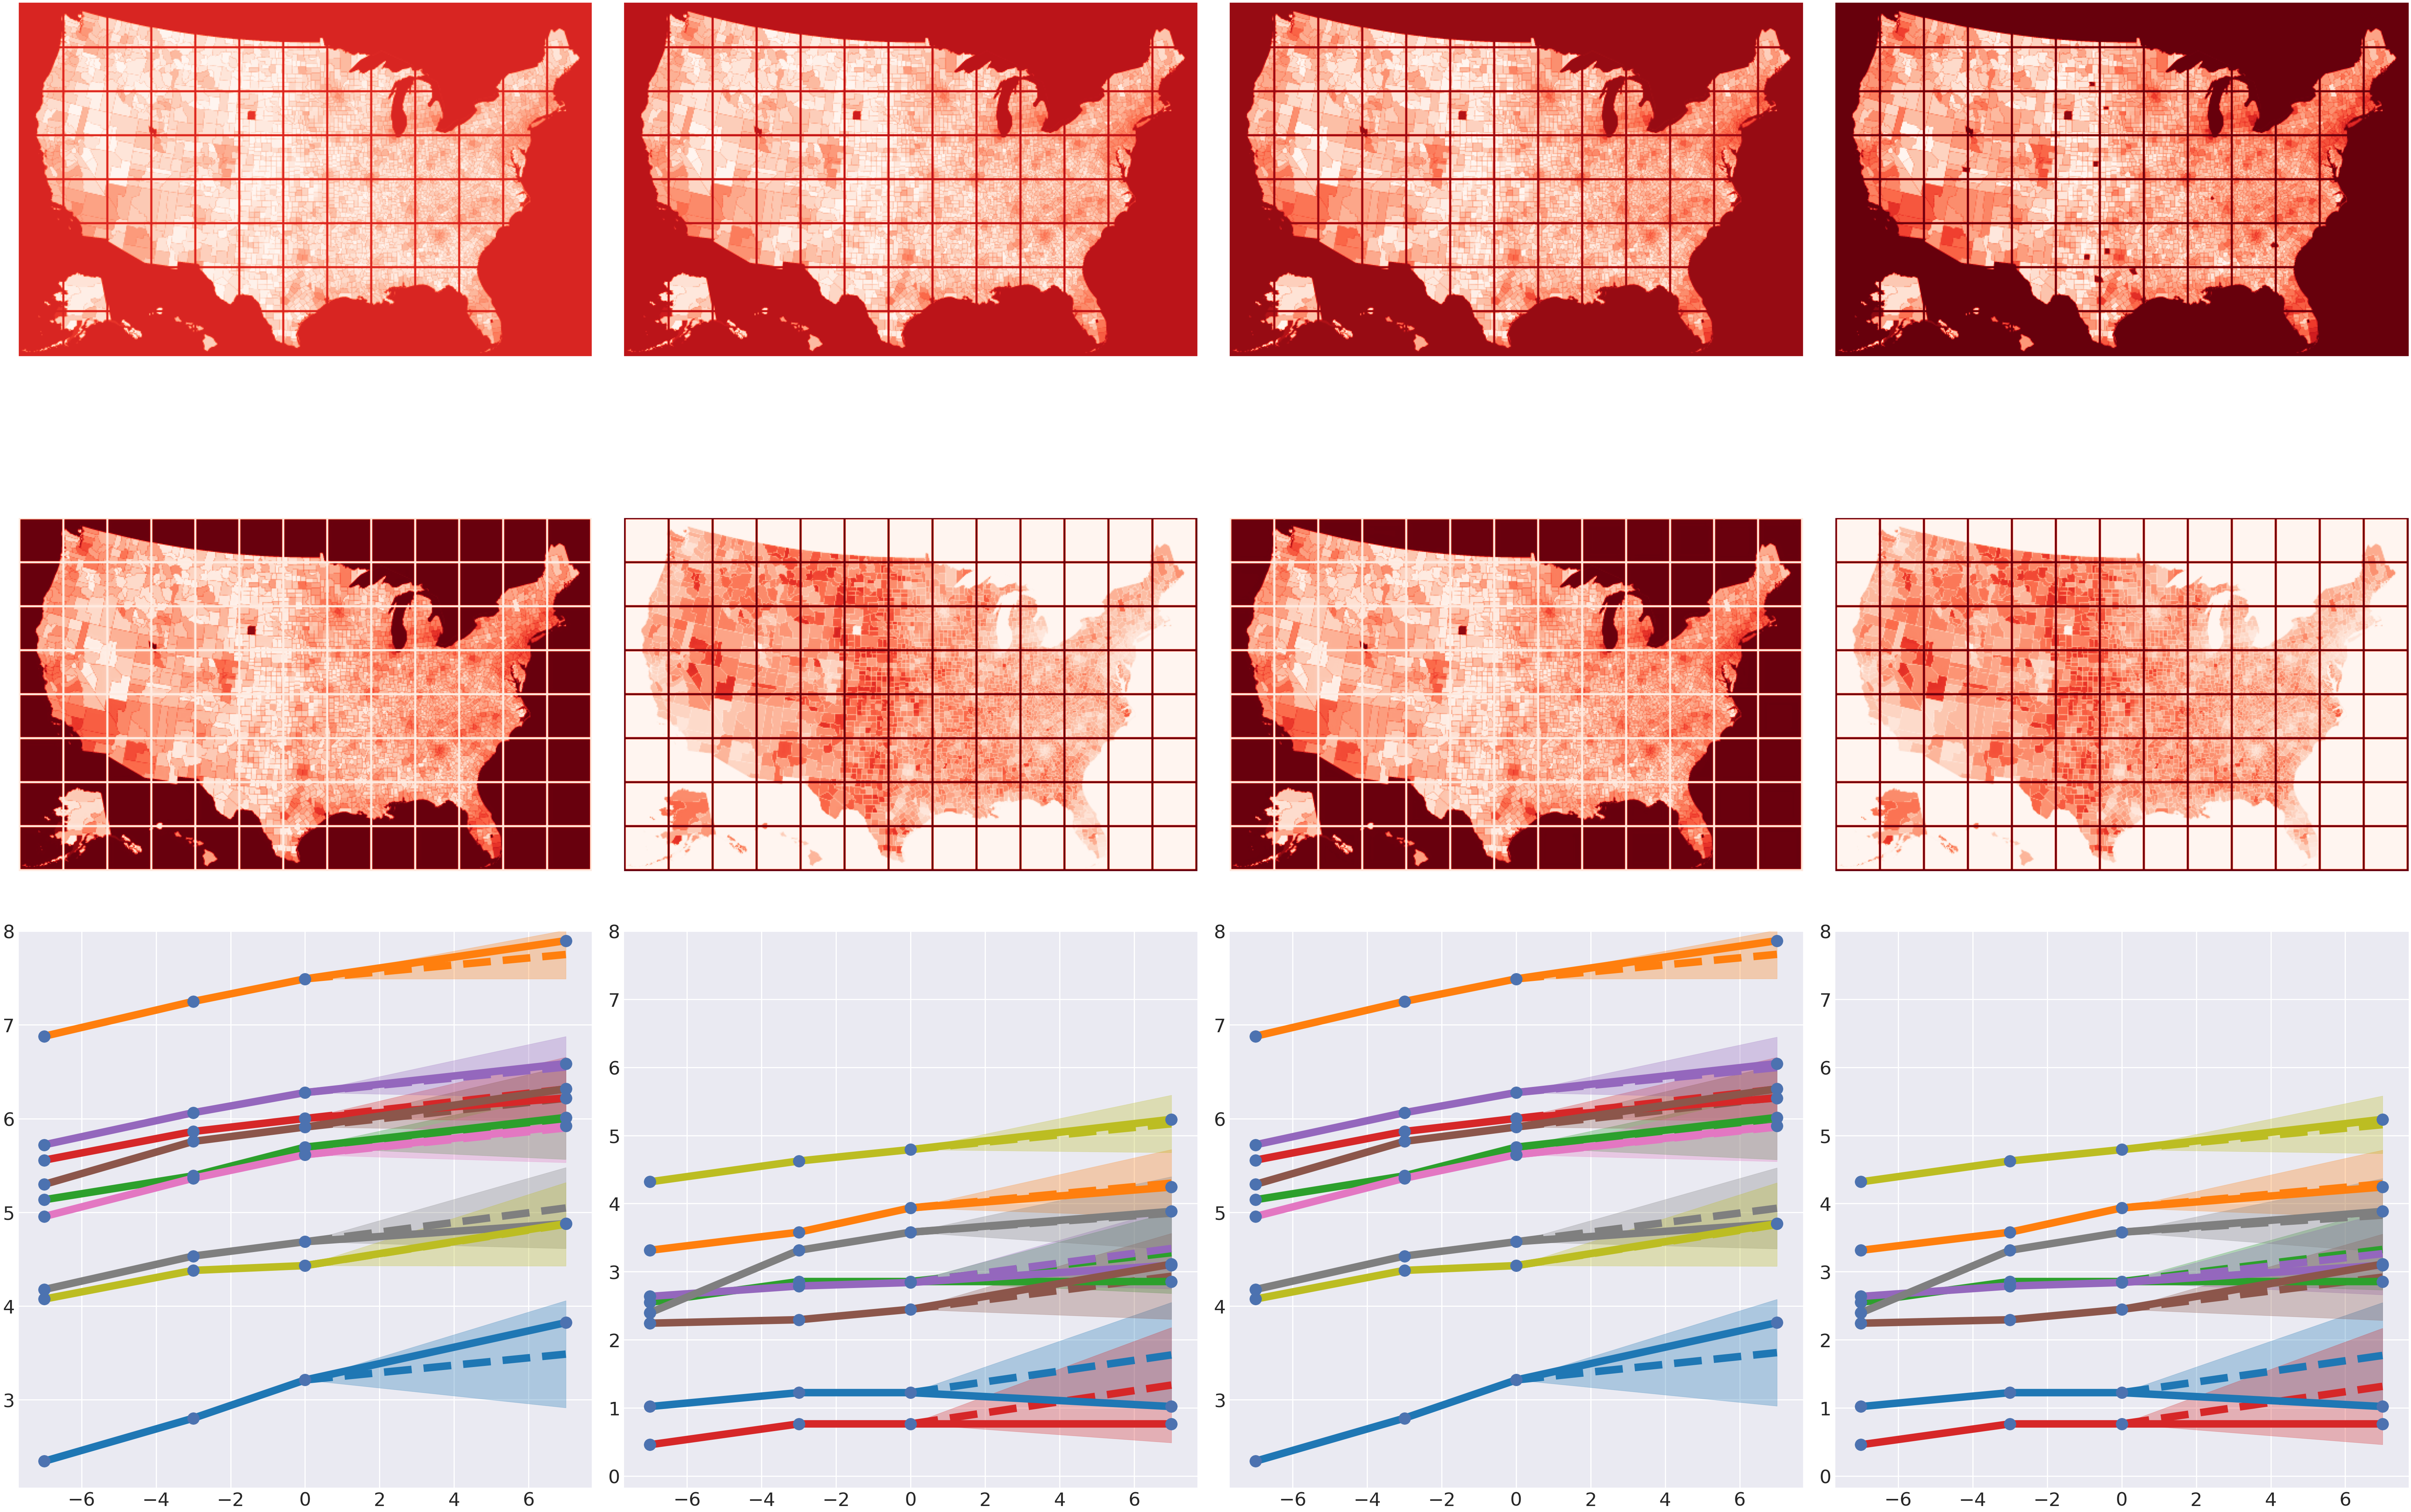

In [10]:
_, _, img_test_datasets = get_covid_datasets(["Covid"], 
                                               root='/share/scratch/xuesongwang/metadata/Covid',
                                               patch_size=104) # to load full 13*8 patches
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
sns.set_theme(style="dark", color_codes=True)

def plot_covid_by_model(trainers_3d, data, namelist, modellist, n_subplot=1):
    def latent_sample(x_context, y_context, x_all, model, sample_size=5):
        y_mean_list = []
        y_std_list = []
        with torch.no_grad():
            for sample in range(sample_size):
                dist, sample, _, _ = model(x_context, y_context, x_all)
                # get the first n_z_sample & the first sample in the batch
                y_mean = dist.mean[0, 0]
                y_std = dist.stddev[0, 0]
                y_mean_list.append(y_mean.detach())
                y_std_list.append(y_std.detach())
        y_mean_list = torch.stack(y_mean_list)
        y_std_list = torch.stack(y_std_list)
        return y_mean_list, y_std_list

    def img2temporal(raw_image, mean_list, std_list, patch_list):
        """
        raw_image: (total_patch, C, T, H, W)
        mean_list: (n_z, total_patch, C, H, W)
        """
        n_sample = 9
        width_list = [5, 20, 35]
        height_list = [5, 20, 35]
        n_patch = 2
        values = np.zeros((n_patch, n_sample, raw_image.shape[2]))
        prediction_mean = np.zeros((n_patch, n_sample, 2))
        prediction_std = np.zeros((n_patch, n_sample, 2))
        for p, patch in enumerate(patch_list):
            for n in range(n_sample):
                width = width_list[n//3]
                height = height_list[n%3]
                values[p, n, :] = raw_image[patch, 0, :, width, height].cpu().numpy()
                prediction_mean[p, n, 0] = values[p, n, -2]  # today's record as a starting point
                prediction_mean[p, n, 1] = mean_list[:, patch, 0, width, height].cpu().numpy()
                prediction_std[p, n, 1] = std_list[:, patch, 0, width, height].cpu().numpy()
        return values, prediction_mean, prediction_std

    N_ROWS = 3
    N_COL = 4

    for col, (dataname, dataset) in enumerate(data.items()):

        fig, axs = plt.subplots(N_ROWS, N_COL, figsize=(30* N_ROWS, 15* N_COL), \
                                gridspec_kw={'width_ratios': [1, 1, 1, 1], 'height_ratios': [1, 1, 1]})
        # load data
        #get one batch
        for batch in tqdm(next(iter(trainers_3d.values())).get_iterator(dataset, training=False)):
            x_context = batch[0]['X_cntxt'].to(device)
            y_context = batch[0]['Y_cntxt'].to(device)
            x_target = batch[0]['X_trgt'].to(device)
            y_target = batch[0]['Y_trgt'].to(device)
            break

        ######## PLot raw image on the first row
        shape = (4, 40, 40)
        if len(y_target.shape) == 5:  # ConvCNP based methods
            raw_image = y_target.permute(0, 4, 1, 2, 3)
        else:
            raw_image = y_target.permute(0, 2, 1).reshape(-1, 1, *shape)

        ## test to mask the patch
        patch_candidates = [47, 83]
        # raw_image[patch_candidates] = 1
        for t in range(shape[0]):
            groudtruth = make_grid(raw_image[:, :, t, :], nrow=13, normalize=True, pad_value=1).permute(1, 2,
                                                                                                        0)  # plus t in increase contrast
            groudtruth = groudtruth * (0.7 + 0.1 * t)  # amplify contrast
            axs[0, t].imshow(groudtruth[:, :, 0].cpu().detach().numpy(), cmap=plt.get_cmap('Reds'), vmin=0, vmax=1)
            axs[0, t].set_yticklabels([])
            axs[0, t].set_xticklabels([])


        ######### Plot prediction samples and uncertainty on the second and third row
        for row, modelname in enumerate(modellist):
            print("now with dataset:%s, model:%s" % (dataname, modelname))
            direct = dataname + '/' + modelname + '/run_0'
            model = trainers_3d[direct].module_.eval().to(device)

            x_context_cp = x_context.clone()
            y_context_cp = y_context.clone()
            x_target_cp = x_target.clone()
            y_target_cp = y_target.clone()

            if 'Conv' in modelname:  # ConvCNP
                x_context_cp = torch.ones(dataset.shape).bool().to(device)
                x_context_cp[:, -1, :] = False
                x_context_cp = x_context_cp.repeat(y_context_cp.shape[0], 1, 1, 1).unsqueeze(dim=-1)
                x_target_cp = torch.ones(dataset.shape).bool().to(device)
                x_target_cp = x_target_cp.repeat(y_target_cp.shape[0], 1, 1, 1).unsqueeze(dim=-1)
                y_context_cp = y_context_cp.contiguous().view(-1, shape[0]-1, shape[1], shape[2], 1)
                y_context_cp_mask = torch.zeros(y_context_cp.shape[0], 1, shape[1], shape[2], 1).to(device)
                y_context_cp = torch.cat([y_context_cp, y_context_cp_mask], dim=1)
                y_target_cp = y_target_cp.contiguous().view(-1, shape[0], shape[1], shape[2], 1)

            # plot the whole country, considering the capacity of the machine, 1 patch at a time
            mean_list = []
            std_list = []

            for i in range(x_context.shape[0]):
#                 print("patch:", i)
                mean_sample, std_sample = latent_sample(x_context_cp[[i]], y_context_cp[[i]], x_target_cp[[i]],
                                                        model, sample_size=1)
                n_z = mean_sample.shape[0]

                # convert from (n_target, c) to img_size
                if len(y_target.shape) != 5:
                    mean_sample = mean_sample.reshape((n_z, *shape, 1))
                    std_sample = std_sample.reshape((n_z, *shape, 1))
                # only use the prediction img, the last timestep
                # (n_z, shape[1], shape[2], 1)
                mean_sample = mean_sample[:, -1, :]
                std_sample = std_sample[:, -1, :]

                mean_list.append(mean_sample.detach())  # detach to save memory
                std_list.append(std_sample.detach())
            # (n_patch, n_z, shape[1], shape[2], 1)
            mean_list = torch.stack(mean_list, dim=0).permute(1, 0, 4, 2, 3)
            std_list = torch.stack(std_list, dim=0).permute(1, 0, 4, 2, 3)
            # make grids for each sample
            for j in range(n_z):
                mean_sample = make_grid(mean_list[j], nrow=13, pad_value=1).permute(1, 2, 0)
                std_sample = make_grid(std_list[j], nrow=13, pad_value=1).permute(1, 2, 0)
                axs[1, 2*row].imshow(mean_sample[:, :, 0].cpu().detach().numpy(), cmap=plt.get_cmap('Reds'))
                axs[1, 2*row+1].imshow(std_sample[:, :, 0].cpu().detach().numpy(), cmap=plt.get_cmap('Reds'))
            [ax.set_yticklabels([]) for ax in axs[1]]
            [ax.set_xticklabels([]) for ax in axs[1]]
            # ######### Plot prediction samples and uncertainty on the second and third row
            scatterdots, pred_mean, pred_std = img2temporal(raw_image, mean_list, std_list, patch_candidates)
            n_patch = scatterdots.shape[0]
            n_sample = scatterdots.shape[1]
            step = np.array([-7, -3, 0, 7])
            color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
            for j in range(n_patch):
                scatter_x = np.repeat(step[None, :], n_sample, axis=0).reshape(-1)
                scatter_y = scatterdots[j].reshape(-1)
                # scatter ground truth
                axs[2, 2*row+j].scatter(scatter_x, scatter_y, s=1000, zorder=2.5)
                # scatter predictions
                # axs[row + 1, j + 2].scatter(np.ones(n_sample)*7, pred_mean[j][:, 1], marker='*', s=2000, zorder=2)
                # plot between
                for n in range(n_sample):
                    # plot the ground truth values
                    axs[2, 2*row+j].plot(step, scatterdots[j, n], linewidth=20, color = color_list[n])
                    # scatter the ground truth values
                    # plot prediction
                    axs[2, 2*row+j].plot(np.array([0, 7]), pred_mean[j, n], linestyle='--', linewidth=20, color=color_list[n],zorder=1)


                    axs[2, 2*row+j].fill_between([0, 7], pred_mean[j, n] - 1.5 * pred_std[j, n],
                                           pred_mean[j, n] + 1.5 * pred_std[j, n],
                                           color=color_list[n],
                                           alpha=0.3,
                                           zorder=1)
                axs[2, 2*row+j].set_ylim(top=8)
                axs[2, 2*row+j].grid("on", linewidth=3)
                axs[2, 2*row+j].tick_params(labelsize=50)
        plt.tight_layout()
    #     fig.savefig('results/imgs/'+dataname + ".png")
        plt.show()
        plt.close(fig)

    
plot_covid_by_model(trainers_3d, img_test_datasets, ['Covid'], ['GBCoNP','GBCoNP']) # draw two samples

### Manipulation of the functional priors
have to reload model as the dimension of the global uncertainty is reduced to 4 for visualzation

In [11]:
# 3D
########### Original  #################################
modeldict = dict()
sample_size = 5
R_DIM = 128
KWARGS = dict(
    is_q_zCct=True,  # will use NPVI => posterior sampling
    n_z_samples_train=sample_size,
    n_z_samples_test=sample_size,
    r_dim=R_DIM,
    # z_dim=R_DIM // 2,
    z_dim=4,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)

CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)

model_3d = partial(
    GridGlobalConvNP,
    x_dim=1, # for gridded conv it's the mask shape
    y_dim=1,
    Conv=lambda y_dim: make_abs_conv(torch.nn.Conv3d)(
        y_dim,
        y_dim,
        groups=y_dim,
        kernel_size=[5, 5, 5],
        padding=[5 // 2, 5 // 2, 5 // 2],
        bias=False,
    ),
    decoder_CNN=partial(
        CNN,
        n_channels=R_DIM,
        Conv=torch.nn.Conv3d,
        Normalization=torch.nn.BatchNorm3d,
        n_blocks=4,
        kernel_size=[5, 5, 5],
        **CNN_KWARGS,
    ),
    **KWARGS,
)

modelname = 'GBCoNP_zdim4'
modeldict[modelname] = model_3d


In [12]:
# load testing parameter
KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    criterion=ELBOLossLNPF,
    chckpnt_dirname="results/pretrained/",
    device=device,  # use GPU if available
    batch_size=1,
    lr=1e-3,
    decay_lr=10,  # decrease learning rate by 10 during training
    # seed=123,
)

get_cntxt_trgt_covid = cntxt_trgt_collate_covid(
    CovidCntxtTrgtGetter(
    context_masker=CovidTimeMasker(timestep=4), target_masker=no_masker,
    )
)

# 1D
trainers_3d = train_models(
    img_test_datasets,
    modeldict,
    test_datasets=img_test_datasets,
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of training for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_covid,
    iterator_valid__collate_fn=get_cntxt_trgt_covid,
    max_epochs=50,
    **KWARGS
)


--- Loading Covid/GBCoNP_zdim4/run_0 ---

Covid/GBCoNP_zdim4/run_0 | best epoch: 91 | train loss: -4342.2444 | valid loss: -6666.4009 | test log likelihood: 5287.6129


In [13]:
def visualize_covid_global_uncertainty(trainers_3d, data, namelist, modellist, n_subplot=1):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    sns.set_theme(style="ticks", color_codes=True)

    def generate_z_sample(z_dist, n_z_sample=1):
        z_mean = z_dist.mean
        z_std = z_dist.stddev
        bs, *data_shape, dim = z_mean.shape
        # rand_index = np.random.choice(np.arange(0, dim, 1), 2, replace=False)  # non-replacement shuffle
        rand_index = [1,2]
        print("index combo:", rand_index)
        z_grid = z_mean[None, None, :].repeat(n_z_sample, n_z_sample, 1, *data_shape, 1)
        if len(data_shape) > 1:
            x = norm.ppf(np.linspace(0.05, 0.95, num=n_z_sample),
                         loc=z_mean[0, 0, 0, 0, rand_index[0]].detach().cpu().numpy(),
                         scale=25 * z_std[0, 0, 0, 0, rand_index[0]].detach().cpu().numpy())
            y = norm.ppf(np.linspace(0.05, 0.95, num=n_z_sample),
                         loc=z_mean[0, 0, 0, 0, rand_index[1]].detach().cpu().numpy(),
                         scale=25* z_std[0, 0, 0, 0, rand_index[1]].detach().cpu().numpy())
        else:
            x = norm.ppf(np.linspace(0.05, 0.95, num=n_z_sample),
                         loc=z_mean[0, 0, rand_index[0]].detach().cpu().numpy(),
                         scale=100 * z_std[0, 0, rand_index[0]].detach().cpu().numpy())
            y = norm.ppf(np.linspace(0.05, 0.95, num=n_z_sample),
                         loc=z_mean[0, 0, rand_index[1]].detach().cpu().numpy(),
                         scale=100 * z_std[0, 0, rand_index[1]].detach().cpu().numpy())
        l_x = x.shape[0]
        l_y = y.shape[0]
        x_grid = np.repeat(x, l_y).reshape(-1, 1)
        y_grid = np.tile(y, l_x).reshape(-1, 1)
        _z = np.concatenate([x_grid, y_grid], axis=1)
        for i in range(n_z_sample):
            for j in range(n_z_sample):
                if len(data_shape) > 1:  # image input
                    z_grid[i, j, :, :, :, :, rand_index[0]] = _z[i * n_z_sample + j, 0]
                    z_grid[i, j, :, :, :, :, rand_index[1]] = _z[i * n_z_sample + j, 1]
                else:
                    z_grid[i, j, :, :, rand_index[0]] = _z[i * n_z_sample + j, 0]
                    z_grid[i, j, :, :, rand_index[1]] = _z[i * n_z_sample + j, 1]
        z_samples = z_grid.view(n_z_sample * n_z_sample, bs, *data_shape, dim)
        return z_samples, rand_index

    def sample_with_global_uncertainty(model, modelname, X_cntxt, Y_cntxt, X_trgt, Y_trgt=None):
        X_cntxt = model.x_encoder(X_cntxt)
        X_trgt = model.x_encoder(X_trgt)
        R = model.encode_globally(X_cntxt, Y_cntxt)

        if model.encoded_path in ["latent", "both"]:
            model.n_z_samples = model.n_z_samples_test
            z_samples, z_samples_mean, q_zCc, q_zCct = model.latent_path(X_cntxt, R, X_trgt, Y_trgt)
            temp1 = q_zCc.mean.detach().cpu().numpy()
            temp2 = q_zCc.stddev.detach().cpu().numpy()
            z_samples, zdim_index = generate_z_sample(q_zCc, 10)
            if 'Co' in modelname:
                z_samples = z_samples.repeat(1, 1, R.shape[-4], R.shape[-3], R.shape[-2], 1)
        else:
            z_samples, z_samples_mean, q_zCc, q_zCct = None, None, None, None

        # size = [n_z_samples, batch_size, *n_trgt, r_dim]
        R_trgt = model.trgt_dependent_representation(X_cntxt, z_samples, R, X_trgt)

        # p(y|cntxt,trgt)
        # batch shape=[n_z_samples, batch_size, *n_trgt] ; event shape=[y_dim]
        p_yCc = model.decode(X_trgt, R_trgt)
        return p_yCc, zdim_index
    
    
    for col, (dataname, dataset) in enumerate(data.items()):
        fig, axs = plt.subplots(1, len(modellist), figsize=(20*len(modellist), 20))
        # load data
        # get one batch
        for batch in tqdm(next(iter(trainers_3d.values())).get_iterator(dataset, training=False)):
            x_context = batch[0]['X_cntxt'].to(device)
            y_context = batch[0]['Y_cntxt'].to(device)
            x_target = batch[0]['X_trgt'].to(device)
            y_target = batch[0]['Y_trgt'].to(device)
            break
        # select the candidate cells
        patch_candidates = [83] #47, 83
        x_context = x_context[patch_candidates]
        y_context = y_context[patch_candidates]
        x_target = x_target[patch_candidates]
        y_target = y_target[patch_candidates]

        shape = (4, 40, 40)
        for row, modelname in enumerate(modellist):
            x_context_cp = x_context.clone()
            y_context_cp = y_context.clone()
            x_target_cp = x_target.clone()
            y_target_cp = y_target.clone()

            ax = axs if len(modellist) == 1 else axs[row]
            print("now with dataset:%s, model:%s" % (dataname, modelname))
            direct = dataname + '/' + modelname + '/run_0'
            model = trainers_3d[direct].module_.eval().to(device)

            if 'Co' in modelname:  # ConvCNP
                x_context_cp = torch.ones(dataset.shape).bool().to(device)
                x_context_cp[:, -1, :] = False
                x_context_cp = x_context_cp.repeat(y_context_cp.shape[0], 1, 1, 1).unsqueeze(dim=-1)
                x_target_cp = torch.ones(dataset.shape).bool().to(device)
                x_target_cp = x_target_cp.repeat(y_target_cp.shape[0], 1, 1, 1).unsqueeze(dim=-1)
                y_context_cp = y_context_cp.contiguous().view(-1, shape[0] - 1, shape[1], shape[2], 1)
                y_context_cp_mask = torch.zeros(y_context_cp.shape[0], 1, shape[1], shape[2], 1).to(device)
                y_context_cp = torch.cat([y_context_cp, y_context_cp_mask], dim=1)
                y_target_cp = y_target_cp.contiguous().view(-1, shape[0], shape[1], shape[2], 1)


            dist, zdim_index = sample_with_global_uncertainty(model, modelname, x_context_cp, y_context_cp, x_target_cp)
            # dist, sample, z_dist, _ = model(x_context_cp, y_context_cp, x_target_cp)
            # [masked_context, predicted_mean*7, predicted_std]
            y_mean = dist.mean[:, 0, :, :]  # (n_z_sample, n_target, y_dim)
            y_std = dist.stddev[:, 0, :, :]
            if 'Co' not in modelname:  # ConvCNP
                y_mean = y_mean.permute(0, 2, 1).view(-1, *dataset.shape)
                y_std = y_std.permute(0, 2, 1).view(-1, *dataset.shape)
            else:
                y_mean = y_mean.permute(0, 4, 1, 2, 3)
                y_std = y_std.permute(0, 4, 1, 2, 3)
            # only the last sample comes with std
            grid_image = y_std.cpu()
            grid_image = grid_image[:,0,[-1],:,:]# only use the last time step
            img_recover = make_grid(grid_image, nrow=10, pad_value=1.).permute(1, 2, 0)
            ax.imshow(img_recover[:, :, 0].detach().numpy(), cmap=plt.get_cmap('Reds'))
            ax.set_ylabel("%s" % modelname.split('_')[0], size=50)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            if row == 0:  # first ax
                ax.set_title(dataname, {'fontsize': 50})
        plt.tight_layout()
    #     fig.savefig('results/imgs/'+dataname+str(patch_candidates[0])+ ".png")
        plt.show()
        plt.close(fig)

  0%|          | 0/7 [00:00<?, ?it/s]


now with dataset:Covid, model:GBCoNP_zdim4
index combo: [1, 2]


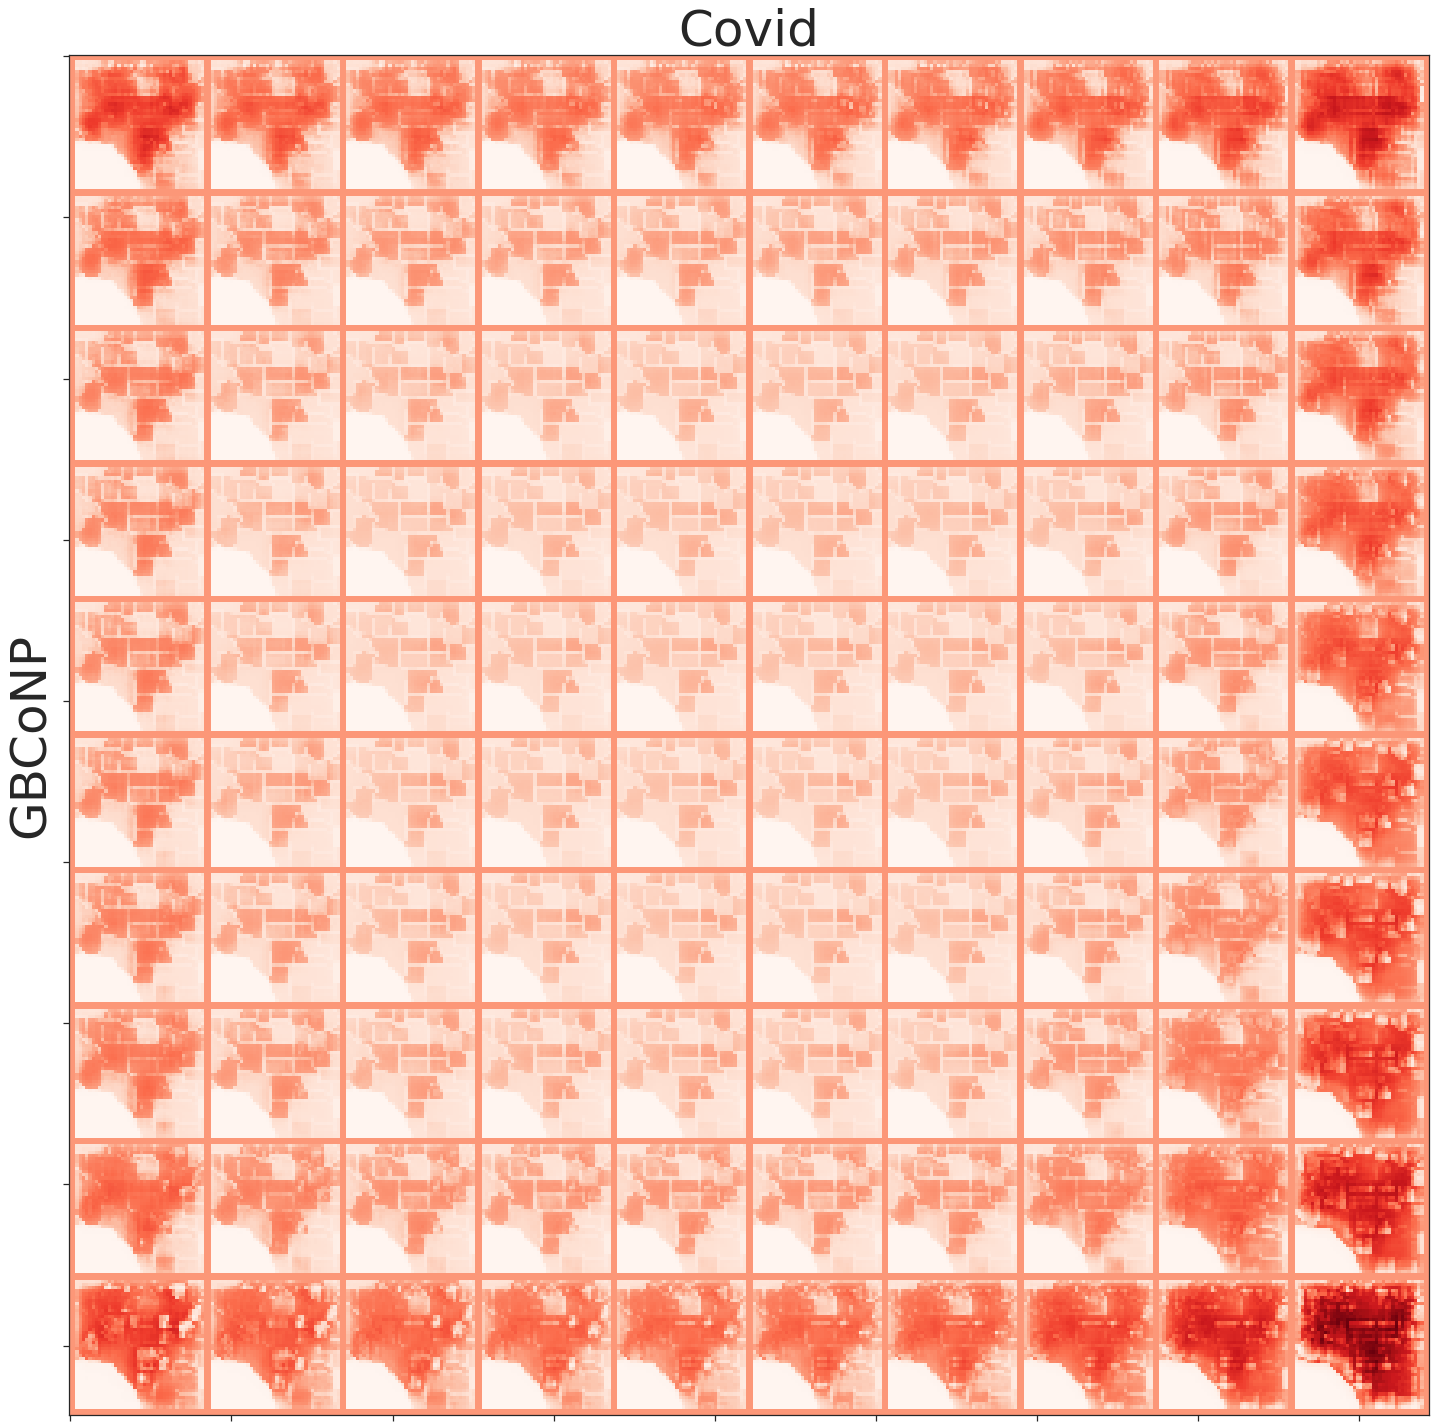

In [14]:
visualize_covid_global_uncertainty(trainers_3d, img_test_datasets, namelist=['GBCoNP'], modellist=['GBCoNP_zdim4'])